In [3]:
## Survival Analysis using Keras
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
from tensorflow import keras
from keras.initializers import glorot_uniform
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD, RMSprop, Adam
from keras.regularizers import l2
import keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from lifelines.utils import concordance_index
import random
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from keras.callbacks import EarlyStopping
import seaborn as sns
import missingno as msno
from tensorflow import keras
from tensorflow.keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [7]:
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)



fold_name = 'fold' + str(4) + '.csv'
print('\t(Val Data: ', fold_name, ')\n')
val_data = pd.read_csv(fold_name) # Fold_2_df.psv

train_data = pd.read_csv('fold' + str(1) + '.csv')
train_data = train_data.append(pd.read_csv('fold' + str(2) + '.csv')) 
train_data = train_data.append(pd.read_csv('fold' + str(3) + '.csv')) 

fold_name1 = 'fold' + str(5) + '.csv'
print('\t(Test Data: ', fold_name1, ')\n')
test_data = pd.read_csv(fold_name1)

X_train = train_data.drop(['Patient ID','Time of Observation','SepsisLabel' ],axis=1)
y_train = train_data['SepsisLabel']
y_train=np.array(y_train)


X_val = val_data.drop(['Patient ID','Time of Observation','SepsisLabel' ],axis=1)
y_val = val_data['SepsisLabel']
y_val=np.array(y_val)


X_test = test_data.drop(['Patient ID','Time of Observation','SepsisLabel' ],axis=1)
y_test = test_data['SepsisLabel']
y_test=np.array(y_test)

#Missing value imputation
from sklearn.preprocessing import Imputer
imputer = Imputer()
X_train = imputer.fit_transform(X_train)
X_val= imputer.transform(X_val)
X_test= imputer.transform(X_test)

#Normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val= scaler.transform(X_val)
X_test= scaler.transform(X_test)


    

	(Val Data:  fold4.csv )

	(Test Data:  fold5.csv )



C:\Users\mdmah\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [9]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [10]:
model = make_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                240       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.predict(X_train[:10])

array([[0.75955427],
       [0.7596772 ],
       [0.7898944 ],
       [0.8028436 ],
       [0.82840204],
       [0.8472123 ],
       [0.6552022 ],
       [0.738803  ],
       [0.64515644],
       [0.547253  ]], dtype=float32)

In [12]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.0590


In [14]:
raw_data=train_data.append(val_data)
raw_data=raw_data.append(test_data)



In [15]:
neg, pos = np.bincount(raw_data['SepsisLabel'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1552210
    Positive: 49995 (3.22% of total)



In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-3.40277296])

In [17]:
model = make_model(output_bias = initial_bias)
model.predict(X_train[:10])

array([[0.04696372],
       [0.04582417],
       [0.05989337],
       [0.06584194],
       [0.0886147 ],
       [0.11713529],
       [0.02666801],
       [0.04169926],
       [0.07146955],
       [0.03905021]], dtype=float32)

In [18]:
results = model.evaluate(X_train,y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.1661


In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0)

In [22]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0)

In [26]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=n, label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=n, label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

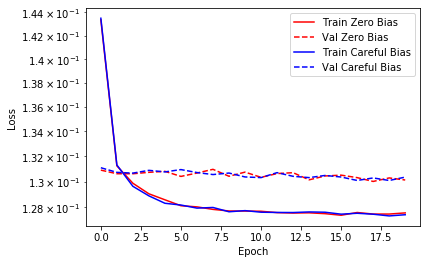

In [27]:
plot_loss(zero_bias_history, "Zero Bias", 'red')
plot_loss(careful_bias_history, "Careful Bias", 'blue')

In [28]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val))

Train on 930524 samples, validate on 310003 samples
Epoch 1/100
930524/930524 [==============================] - 8s 8us/sample - loss: 0.1431 - tp: 440.0000 - fp: 1647.0000 - tn: 898622.0000 - fn: 29815.0000 - accuracy: 0.9662 - precision: 0.2108 - recall: 0.0145 - auc: 0.6388 - val_loss: 0.1312 - val_tp: 127.0000 - val_fp: 263.0000 - val_tn: 299850.0000 - val_fn: 9763.0000 - val_accuracy: 0.9677 - val_precision: 0.3256 - val_recall: 0.0128 - val_auc: 0.7009
Epoch 2/100
930524/930524 [==============================] - 7s 7us/sample - loss: 0.1310 - tp: 676.0000 - fp: 1590.0000 - tn: 898679.0000 - fn: 29579.0000 - accuracy: 0.9665 - precision: 0.2983 - recall: 0.0223 - auc: 0.7368 - val_loss: 0.1307 - val_tp: 137.0000 - val_fp: 267.0000 - val_tn: 299846.0000 - val_fn: 9753.0000 - val_accuracy: 0.9677 - val_precision: 0.3391 - val_recall: 0.0139 - val_auc: 0.7071
Epoch 3/100
930524/930524 [==============================] - 7s 7us/sample - loss: 0.1296 - tp: 660.0000 - fp: 1501.0000 - tn:

In [36]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color='red', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='blue', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, 1])
    elif metric == 'auc':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0,1])

    plt.legend()

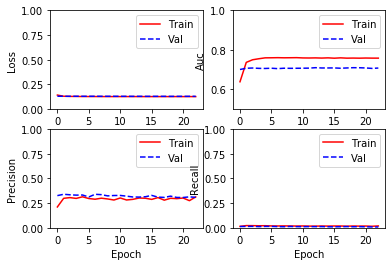

In [37]:
plot_metrics(baseline_history)

In [38]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

In [39]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.13074157081568974
tp :  157.0
fp :  568.0
tn :  301265.0
fn :  9693.0
accuracy :  0.96707875
precision :  0.21655172
recall :  0.015939087
auc :  0.7067907

Legitimate Transactions Detected (True Negatives):  301265
Legitimate Transactions Incorrectly Detected (False Positives):  568
Fraudulent Transactions Missed (False Negatives):  9693
Fraudulent Transactions Detected (True Positives):  157
Total Fraudulent Transactions:  9850


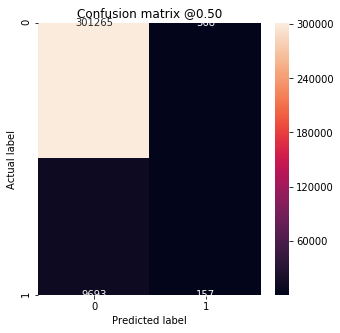

In [40]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

In [46]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100])
    plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

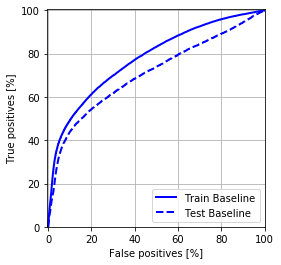

In [47]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color='blue')
plot_roc("Test Baseline", y_test, test_predictions_baseline, color='blue', linestyle='--')
plt.legend(loc='lower right')

In [49]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.52
Weight for class 1: 15.52


In [50]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val),
    # The class weights go here
    class_weight=class_weight) 

Train on 930524 samples, validate on 310003 samples
Epoch 1/100
930524/930524 [==============================] - 9s 10us/sample - loss: 1.0087 - tp: 9427.0000 - fp: 145025.0000 - tn: 755244.0000 - fn: 20828.0000 - accuracy: 0.8218 - precision: 0.0610 - recall: 0.3116 - auc: 0.5934 - val_loss: 0.4390 - val_tp: 4388.0000 - val_fp: 38169.0000 - val_tn: 261944.0000 - val_fn: 5502.0000 - val_accuracy: 0.8591 - val_precision: 0.1031 - val_recall: 0.4437 - val_auc: 0.7124
Epoch 2/100
930524/930524 [==============================] - 7s 7us/sample - loss: 0.7321 - tp: 15220.0000 - fp: 187529.0000 - tn: 712740.0000 - fn: 15035.0000 - accuracy: 0.7823 - precision: 0.0751 - recall: 0.5031 - auc: 0.6962 - val_loss: 0.4650 - val_tp: 4581.0000 - val_fp: 39291.0000 - val_tn: 260822.0000 - val_fn: 5309.0000 - val_accuracy: 0.8561 - val_precision: 0.1044 - val_recall: 0.4632 - val_auc: 0.7193
Epoch 3/100
930524/930524 [==============================] - 6s 7us/sample - loss: 0.6857 - tp: 15730.0000 - fp:

In [51]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.48739380878776484
tp :  4613.0
fp :  39314.0
tn :  262519.0
fn :  5237.0
accuracy :  0.8570631
precision :  0.10501514
recall :  0.46832487
auc :  0.715882

Legitimate Transactions Detected (True Negatives):  262519
Legitimate Transactions Incorrectly Detected (False Positives):  39314
Fraudulent Transactions Missed (False Negatives):  5237
Fraudulent Transactions Detected (True Positives):  4613
Total Fraudulent Transactions:  9850


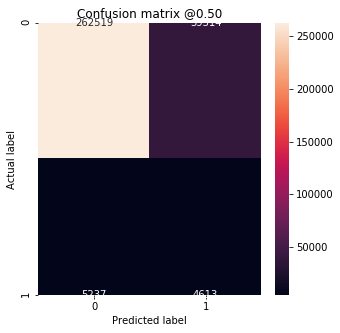

In [52]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

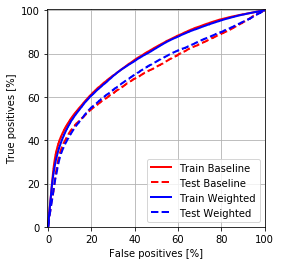

In [53]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color='red')
plot_roc("Test Baseline", y_test, test_predictions_baseline, color='red', linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color='blue')
plot_roc("Test Weighted", y_test, test_predictions_weighted, color='blue', linestyle='--')


plt.legend(loc='lower right')